<h1 class='font-effect-3d' style='color:#37c9e1; font-family:Orbitron;'> &#x1F310; &nbsp; Code Library, Styling, and Links</h1>
`GITHUB` Version: &nbsp; &#x1F4D8; &nbsp; [kaggle_passnyc2.ipynb](https://github.com/OlgaBelitskaya/kaggle_notebooks/blob/master/kaggle_passnyc2.ipynb)

`R` Version: &nbsp; &#x1F4D8; &nbsp; [kaggle_passnyc2_R.ipynb](https://github.com/OlgaBelitskaya/kaggle_notebooks/blob/master/kaggle_passnyc2_R.ipynb)

The previous notebooks: 

&#x1F4D8; &nbsp; [PASSNYC. Data Exploration](https://www.kaggle.com/olgabelitskaya/passnyc-data-exploration); &nbsp; [PASSNYC. Data Exploration R](https://www.kaggle.com/olgabelitskaya/passnyc-data-exploration-r)

Useful `LINKS`: 

&#x1F4E1; &nbsp; [School Quality Reports. Educator Guide](http://schools.nyc.gov/NR/rdonlyres/967E0EE1-7E5D-4E47-BC21-573FEEE23AE2/0/201516EducatorGuideHS9252017.pdf) & [New York City Department of Education](https://www.schools.nyc.gov)

&#x1F4E1; &nbsp; [NYC OpenData](https://opendata.cityofnewyork.us/)

&#x1F4E1; &nbsp; [Pandas Visualization](https://pandas.pydata.org/pandas-docs/stable/visualization.html) & [Pandas Styling](https://pandas.pydata.org/pandas-docs/stable/style.html)

In [1]:
%%html
<style> 
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto&effect=3d');
body {background-color: gainsboro;} 
h3 {color:#818286; font-family:Roboto;}
span {color:black; text-shadow:4px 4px 4px #aaa;}
div.output_prompt,div.output_area pre {color:slategray;}
div.input_prompt,div.output_subarea {color:#37c9e1;}      
div.output_stderr pre {background-color:gainsboro;}  
div.output_stderr {background-color:slategrey;}       
</style>

In [2]:
import numpy as np,pandas as pd,geopandas as gpd
import pylab as plt,seaborn as sns
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
style_dict={'background-color':'slategray','color':'#37c9e1',
            'border-color':'white','font-family':'Roboto'}
plt.style.use('seaborn-whitegrid')
path='../input/data-science-for-good/'
path2='../input/ny-school-districts/'

<h1 class='font-effect-3d' style='color:#37c9e1; font-family:Orbitron;'>  &#x1F310; &nbsp; Loading & Preprocessing the Data <h1>

In [3]:
school_explorer=pd.read_csv(path+'2016 School Explorer.csv')
d5_shsat=pd.read_csv(path+'D5 SHSAT Registrations and Testers.csv')
school_explorer.shape,d5_shsat.shape

((1272, 161), (140, 7))

In [4]:
drop_list=['Adjusted Grade','New?','Other Location Code in LCGMS']
school_explorer=school_explorer.drop(drop_list,axis=1)
school_explorer.loc[[427,1023,712,908],'School Name']=\
['P.S. 212 D12','P.S. 212 D30','P.S. 253 D21','P.S. 253 D27']
school_explorer['School Income Estimate']=\
school_explorer['School Income Estimate'].astype('str') 
for s in [",","$"," "]:
    school_explorer['School Income Estimate']=\
    school_explorer['School Income Estimate'].str.replace(s,"")
school_explorer['School Income Estimate']=\
school_explorer['School Income Estimate'].str.replace("nan","0")
school_explorer['School Income Estimate']=\
school_explorer['School Income Estimate'].astype(float)
school_explorer['School Income Estimate'].replace(0,np.NaN,inplace=True)
percent_list=['Percent ELL','Percent Asian','Percent Black',
              'Percent Hispanic','Percent Black / Hispanic',
              'Percent White','Student Attendance Rate',
              'Percent of Students Chronically Absent',
              'Rigorous Instruction %','Collaborative Teachers %',
              'Supportive Environment %','Effective School Leadership %',
              'Strong Family-Community Ties %','Trust %']
target_list=['Average ELA Proficiency','Average Math Proficiency']
economic_list=['Economic Need Index','School Income Estimate']
rating_list=['Rigorous Instruction Rating','Collaborative Teachers Rating',
             'Supportive Environment Rating','Effective School Leadership Rating',
             'Strong Family-Community Ties Rating','Trust Rating',
             'Student Achievement Rating']
for el in percent_list:
    school_explorer[el]=school_explorer[el].astype('str')
    school_explorer[el]=school_explorer[el].str.replace("%","")
    school_explorer[el]=school_explorer[el].str.replace("nan","0")
    school_explorer[el]=school_explorer[el].astype(float)
    school_explorer[el].replace(0,np.NaN,inplace=True)
    school_explorer[el]=school_explorer[el].interpolate()
for el in target_list+economic_list:
    school_explorer[el]=school_explorer[el].interpolate()
for el in rating_list:
    moda_value=school_explorer[el].value_counts().idxmax()
    school_explorer[el]=school_explorer[el].fillna(moda_value)   
print('Number of Missing Values: ',sum(school_explorer.isna().sum()))

Number of Missing Values:  0


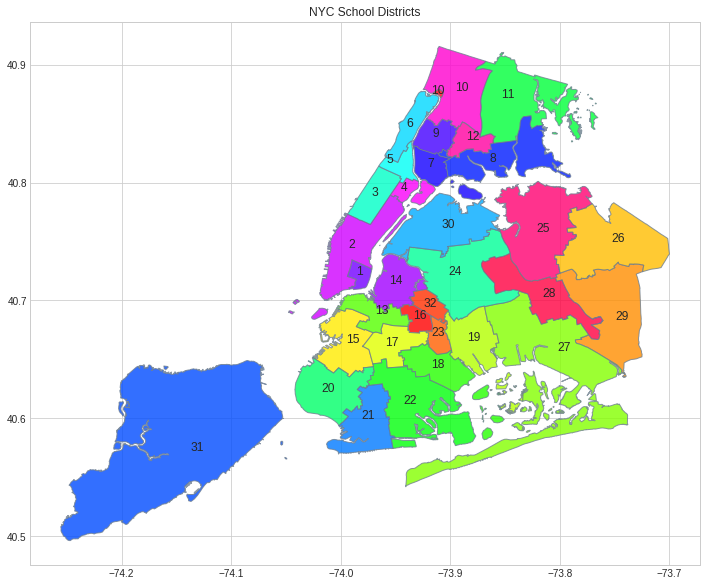

In [5]:
districts=gpd.GeoDataFrame.from_file(path2+"nysd.shp")
# http://prj2epsg.org
districts.crs=('+init=EPSG:2263')
districts=districts.to_crs(('+init=EPSG:4326'))
districts['coords']=\
districts['geometry'].apply(lambda x:x.representative_point().coords[:])
districts['coords']=[coords[0] for coords in districts['coords']]
fig,ax=plt.subplots(1,figsize=(12,10))
districts.plot(ax=ax,cmap=cm.hsv,alpha=.8,edgecolor='slategray')
for idx,row in districts.iterrows():
    plt.annotate(s=row['SchoolDist'],xy=row['coords'],
                 horizontalalignment='center',fontsize=12)
plt.title('NYC School Districts');

<h1 class='font-effect-3d' style='color:#37c9e1; font-family:Orbitron;'> &#x1F310; &nbsp; Classification of Variables </h1>

In [6]:
school_explorer.describe(include=[np.number]).T.head(23)\
.style.set_properties(**style_dict)

,count,mean,std,min,25%,50%,75%,max
SED Code,1272,3.2867e+11,1.22202e+10,3.075e+11,3.20875e+11,3.315e+11,3.424e+11,3.53101e+11
District,1272,16.1352,9.24527,1,9,15,24,32
Latitude,1272,40.7345,0.0866023,40.5078,40.6695,40.723,40.8156,40.9035
Longitude,1272,-73.9183,0.0805765,-74.244,-73.9571,-73.9206,-73.8793,-73.7089
Zip,1272,10815.7,529.589,10001,10452,11203,11232,11694
Economic Need Index,1272,0.671995,0.209518,0.049,0.551,0.72825,0.84,0.957
School Income Estimate,1272,48013.7,21007.7,16901.7,33381.1,43571.8,57782.9,181382
Percent ELL,1272,12.6639,11.2419,1,4,9,18,99
Percent Asian,1272,11.9772,17.4887,1,1.5,4,14,95
Percent Black,1272,32.103,28.7148,1,7,24,55.25,97


In [7]:
school_explorer.describe(include=[np.object]).T\
.style.set_properties(**style_dict)

,count,unique,top,freq
School Name,1272,1272,P.S. 150 CHRISTOPHER,1
Location Code,1272,1272,11X108,1
Address (Full),1272,1091,"3710 BARNES AVE BRONX, NY 10467",3
City,1272,45,BROOKLYN,411
Grades,1272,41,"PK,0K,01,02,03,04,05",400
Grade Low,1272,10,PK,525
Grade High,1272,11,05,626
Community School?,1272,2,No,1196
Rigorous Instruction Rating,1272,4,Meeting Target,629
Collaborative Teachers Rating,1272,4,Meeting Target,651


In [8]:
numeric_list1=school_explorer.describe(include=[np.number]).columns[:23]
numeric_list2=school_explorer.describe(include=[np.number]).columns[23:]
object_list=school_explorer.describe(include=[np.object]).columns

Of course, the variables `SED Code`, `District`, `Zip` are categorical. 

Just categories are denoted by numeric values.

Let's convert string values of other categorical features into numeric.

In [9]:
print('District: \n',set(school_explorer['District']),'\n')
print('City: \n',set(school_explorer['City']),'\n')
print('Grades: \n',set(school_explorer['Grades']),'\n')
print('Community School?: \n',
      set(school_explorer['Community School?']),'\n')
print('Rigorous Instruction Rating: \n',
      set(school_explorer['Rigorous Instruction Rating']),'\n')
print('Collaborative Teachers Rating: \n',
      set(school_explorer['Collaborative Teachers Rating']),'\n')
print('Supportive Environment Rating: \n',
      set(school_explorer['Supportive Environment Rating']),'\n')
print('Effective School Leadership Rating: \n',
      set(school_explorer['Effective School Leadership Rating']),'\n')
print('Strong Family-Community Ties Rating: \n',
      set(school_explorer['Strong Family-Community Ties Rating']),'\n')
print('Trust Rating: \n',
      set(school_explorer['Trust Rating']),'\n')
print('Student Achievement Rating: \n',
      set(school_explorer['Student Achievement Rating']),'\n')

District: 
 {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32} 

City: 
 {'BELLEROSE', 'ARVERNE', 'SPRINGFIELD GARDENS', 'FLORAL PARK', 'ROCKAWAY PARK', 'EAST ELMHURST', 'DOUGLASTON', 'ROSEDALE', 'MASPETH', 'BRONX', 'GLENDALE', 'CORONA', 'OZONE PARK', 'ASTORIA', 'QUEENS VILLAGE', 'BROAD CHANNEL', 'FLUSHING', 'LONG ISLAND CITY', 'WOODSIDE', 'FAR ROCKAWAY', 'REGO PARK', 'SOUTH RICHMOND HILL', 'WHITESTONE', 'HOWARD BEACH', 'CAMBRIA HEIGHTS', 'HOLLIS', 'ROCKAWAY BEACH', 'JAMAICA', 'SOUTH OZONE PARK', 'ELMHURST', 'SAINT ALBANS', 'KEW GARDENS', 'NEW YORK', 'COLLEGE POINT', 'STATEN ISLAND', 'BROOKLYN', 'BAYSIDE', 'RIDGEWOOD', 'RICHMOND HILL', 'FOREST HILLS', 'JACKSON HEIGHTS', 'MIDDLE VILLAGE', 'WOODHAVEN', 'LITTLE NECK', 'ROOSEVELT ISLAND'} 

Grades: 
 {'01,02,03,04,05,06,07,08', '06,07,08,09,10', '0K,01,02,03,04,05,06,07,08', 'PK,0K,01,02,03,04', 'PK,0K,01,02,03,04,05', '06,07,08,09,10,11,12', 'PK,0K,01,02,03,04,05,06,07,0

In [10]:
category_list=['District','Community School?','City','Grades']             
for feature in category_list:
    feature_cat=pd.factorize(school_explorer[feature])
    school_explorer[feature]=feature_cat[0]  
for feature in rating_list:
    feature_pairs=dict(zip(['Not Meeting Target','Meeting Target', 
                            'Approaching Target','Exceeding Target'],
                            ['0','2','1','3']))
    school_explorer[feature].replace(feature_pairs,inplace=True)
    school_explorer[feature]=school_explorer[feature].astype(int)

In [11]:
category_list=list(category_list+rating_list)
numeric_list=list(numeric_list1[5:21].append(numeric_list2))
print('Categorical features: \n',category_list,'\n', 
      'Numeric features: \n',numeric_list)

Categorical features: 
 ['District', 'Community School?', 'City', 'Grades', 'Rigorous Instruction Rating', 'Collaborative Teachers Rating', 'Supportive Environment Rating', 'Effective School Leadership Rating', 'Strong Family-Community Ties Rating', 'Trust Rating', 'Student Achievement Rating'] 
 Numeric features: 
 ['Economic Need Index', 'School Income Estimate', 'Percent ELL', 'Percent Asian', 'Percent Black', 'Percent Hispanic', 'Percent Black / Hispanic', 'Percent White', 'Student Attendance Rate', 'Percent of Students Chronically Absent', 'Rigorous Instruction %', 'Collaborative Teachers %', 'Supportive Environment %', 'Effective School Leadership %', 'Strong Family-Community Ties %', 'Trust %', 'Grade 3 ELA - All Students Tested', 'Grade 3 ELA 4s - All Students', 'Grade 3 ELA 4s - American Indian or Alaska Native', 'Grade 3 ELA 4s - Black or African American', 'Grade 3 ELA 4s - Hispanic or Latino', 'Grade 3 ELA 4s - Asian or Pacific Islander', 'Grade 3 ELA 4s - White', 'Grade 3 

In [12]:
print('District: \n',set(school_explorer['District']),'\n')
print('City: \n',set(school_explorer['City']),'\n')
print('Grades: \n',set(school_explorer['Grades']),'\n')
print('Community School?: \n',
      set(school_explorer['Community School?']),'\n')
print('Rigorous Instruction Rating: \n',
      set(school_explorer['Rigorous Instruction Rating']),'\n')
print('Collaborative Teachers Rating: \n',
      set(school_explorer['Collaborative Teachers Rating']),'\n')
print('Supportive Environment Rating: \n',
      set(school_explorer['Supportive Environment Rating']),'\n')
print('Effective School Leadership Rating: \n',
      set(school_explorer['Effective School Leadership Rating']),'\n')
print('Strong Family-Community Ties Rating: \n',
      set(school_explorer['Strong Family-Community Ties Rating']),'\n')
print('Trust Rating: \n',
      set(school_explorer['Trust Rating']),'\n')
print('Student Achievement Rating: \n',
      set(school_explorer['Student Achievement Rating']),'\n')

District: 
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31} 

City: 
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44} 

Grades: 
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40} 

Community School?: 
 {0, 1} 

Rigorous Instruction Rating: 
 {0, 1, 2, 3} 

Collaborative Teachers Rating: 
 {0, 1, 2, 3} 

Supportive Environment Rating: 
 {0, 1, 2, 3} 

Effective School Leadership Rating: 
 {0, 1, 2, 3} 

Strong Family-Community Ties Rating: 
 {0, 1, 2, 3} 

Trust Rating: 
 {0, 1, 2, 3} 

Student Achievement Rating: 
 {0, 1, 2, 3} 



<h1 class='font-effect-3d' style='color:#37c9e1; font-family:Orbitron;'>  &#x1F310; &nbsp; Clustering </h1>
### By education results and economic indicators

In [13]:
X=school_explorer[target_list+economic_list]; nk=10
clf=KMeans(n_clusters=nk,random_state=23)
cluster_labels=clf.fit_predict(np.array(X))
school_explorer['Education Clusters']=cluster_labels
X.groupby(school_explorer['Education Clusters']).mean()\
.sort_values('Average Math Proficiency')\
.style.set_properties(**style_dict)

,Average ELA Proficiency,Average Math Proficiency,Economic Need Index,School Income Estimate
Education Clusters,,,,
6,2.30547,2.39273,0.859856,25823.8
0,2.38389,2.49687,0.809264,33640.1
7,2.43594,2.5833,0.750129,40172.9
2,2.51934,2.66065,0.678411,47186.9
9,2.62964,2.80178,0.581355,56385.4
5,2.71727,2.85442,0.483175,66065
1,2.90489,3.08352,0.353943,77967.7
4,2.96843,3.16599,0.353188,94914.6
8,3.32176,3.48265,0.197471,116097


Let's arrange these clusters in accordance with educational achievements.

In [14]:
indices=list(X.groupby(school_explorer['Education Clusters']).mean()\
             .sort_values('Average Math Proficiency').index)
feature_pairs=dict(zip(indices,range(10,20)))
school_explorer['Education Clusters'].replace(feature_pairs,inplace=True)
feature_pairs=dict(zip(range(10,20),range(0,10)))
school_explorer['Education Clusters'].replace(feature_pairs,inplace=True)
X.groupby(school_explorer['Education Clusters']).mean()\
.sort_values('Average Math Proficiency')\
.style.set_properties(**style_dict)

,Average ELA Proficiency,Average Math Proficiency,Economic Need Index,School Income Estimate
Education Clusters,,,,
0,2.30547,2.39273,0.859856,25823.8
1,2.38389,2.49687,0.809264,33640.1
2,2.43594,2.5833,0.750129,40172.9
3,2.51934,2.66065,0.678411,47186.9
4,2.62964,2.80178,0.581355,56385.4
5,2.71727,2.85442,0.483175,66065
6,2.90489,3.08352,0.353943,77967.7
7,2.96843,3.16599,0.353188,94914.6
8,3.32176,3.48265,0.197471,116097


The location of the results with good quality by districts and cluster types of schools can be assessed using visualization.

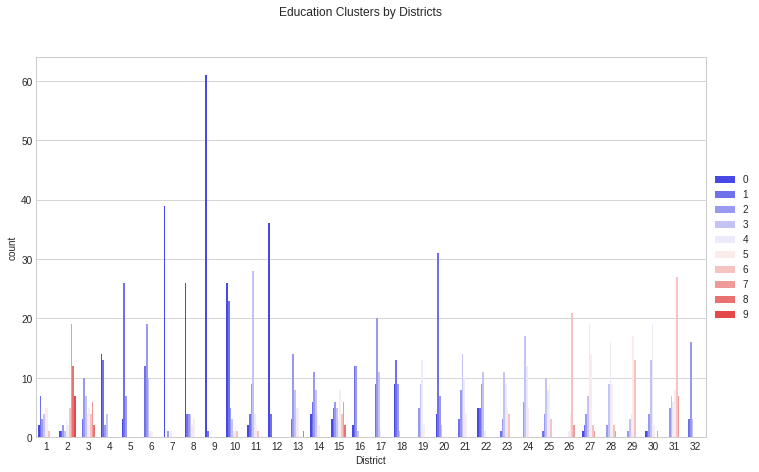

In [15]:
fig,ax=plt.subplots(1,figsize=(12,7))
plt.suptitle('Education Clusters by Districts')
sns.countplot(x="District",hue="Education Clusters", 
              data=school_explorer,ax=ax,palette='bwr')
ax.legend(loc='center left',bbox_to_anchor=(1,.5))
ax.set_xticklabels(range(1,33));

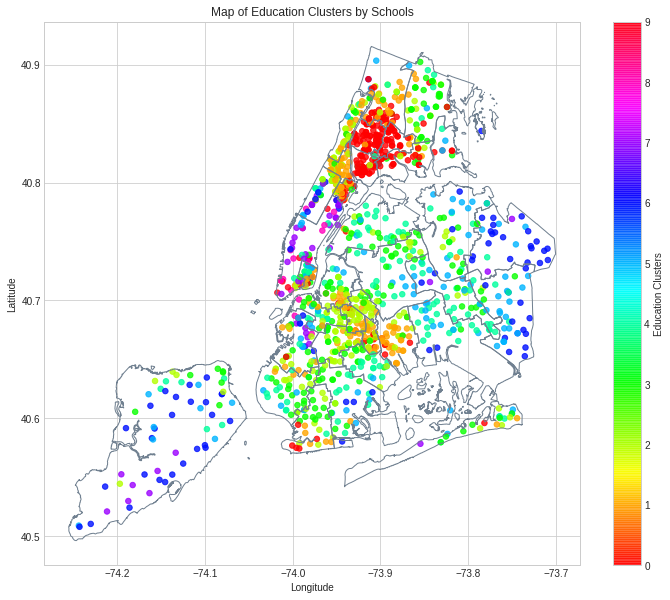

In [16]:
fig,ax=plt.subplots(1,figsize=(12,10))
school_explorer.plot(kind="scatter",x="Longitude",y="Latitude",
                     s=30,c="Education Clusters",ax=ax,
                     title='Map of Education Clusters by Schools',
                     cmap=cm.hsv,colorbar=True,alpha=.8)
districts.plot(ax=ax,color='none',edgecolor='slategray');

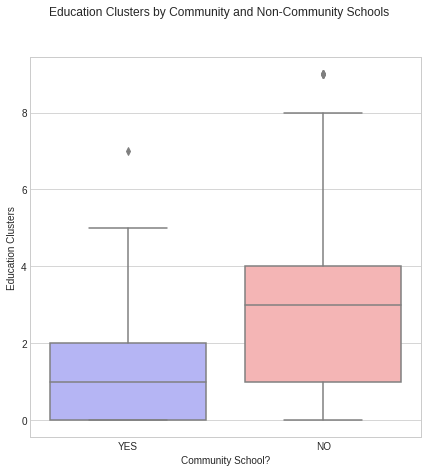

In [17]:
fig,ax=plt.subplots(1,figsize=(7,7))
plt.suptitle('Education Clusters by Community and Non-Community Schools')
sns.boxplot(x="Community School?",y="Education Clusters",
            data=school_explorer,ax=ax,palette='bwr')
ax.set_xticklabels(['YES','NO']);

### By education results and social environment

In [18]:
cluster_list2=['Average ELA Proficiency','Average Math Proficiency',
               'Student Attendance Rate',
               'Percent of Students Chronically Absent',                     
               'Rigorous Instruction %','Collaborative Teachers %',
               'Supportive Environment %','Effective School Leadership %',
               'Strong Family-Community Ties %','Trust %']
X=school_explorer[cluster_list2]; nk=10
clf=KMeans(n_clusters=nk,random_state=23)
cluster_labels=clf.fit_predict(np.array(X))
school_explorer['Education Clusters']=cluster_labels
X.groupby(school_explorer['Education Clusters']).mean()\
.sort_values('Average Math Proficiency').T\
.style.set_properties(**style_dict)

Education Clusters,6,2,9,7,3,0,5,8,1,4
Average ELA Proficiency,2.1675,2.21153,2.26448,2.38632,2.42459,2.45779,2.66479,2.77257,2.82916,3.174
Average Math Proficiency,2.17996,2.23504,2.28699,2.48487,2.5167,2.56442,2.8737,2.96929,3.06968,3.804
Student Attendance Rate,88.8983,89.7541,91.7622,92.0079,93.2722,93.7404,95.4168,95.8551,95.4587,94.875
Percent of Students Chronically Absent,43.0339,39.6098,29.0979,29.5,21.8795,20.2212,11.3462,9.48351,11.0014,100
Rigorous Instruction %,84.1186,89.3374,85.028,94.2677,89.5417,82.1058,87.1259,89.678,94.6179,94.8
Collaborative Teachers %,76.0169,89.9959,82.4615,94.4724,89.284,71.8846,83.2517,90.8251,95.106,94
Supportive Environment %,82.0678,86.6626,84.2238,93.4646,87.5851,83.125,87.8846,88.0295,95.0467,91.6
Effective School Leadership %,65.6441,83.4675,73.6434,89.7402,82.9674,59.2019,73.9406,85.4635,90.4163,87.3
Strong Family-Community Ties %,78.9831,83.1138,79.993,86.9843,82.5824,78.3942,81.2867,81.2066,87.8563,92.5
Trust %,81.1017,91.2439,85.993,95.3307,91.2215,77.875,86.5979,91.977,95.6618,94


In [19]:
indices=list(X.groupby(school_explorer['Education Clusters']).mean()\
             .sort_values('Average Math Proficiency').index)
feature_pairs=dict(zip(indices,range(10,20)))
school_explorer['Education Clusters'].replace(feature_pairs,inplace=True)
feature_pairs=dict(zip(range(10,20),range(0,10)))
school_explorer['Education Clusters'].replace(feature_pairs,inplace=True)
X.groupby(school_explorer['Education Clusters']).mean()\
.sort_values('Average Math Proficiency').T\
.style.set_properties(**style_dict)

Education Clusters,0,1,2,3,4,5,6,7,8,9
Average ELA Proficiency,2.1675,2.21153,2.26448,2.38632,2.42459,2.45779,2.66479,2.77257,2.82916,3.174
Average Math Proficiency,2.17996,2.23504,2.28699,2.48487,2.5167,2.56442,2.8737,2.96929,3.06968,3.804
Student Attendance Rate,88.8983,89.7541,91.7622,92.0079,93.2722,93.7404,95.4168,95.8551,95.4587,94.875
Percent of Students Chronically Absent,43.0339,39.6098,29.0979,29.5,21.8795,20.2212,11.3462,9.48351,11.0014,100
Rigorous Instruction %,84.1186,89.3374,85.028,94.2677,89.5417,82.1058,87.1259,89.678,94.6179,94.8
Collaborative Teachers %,76.0169,89.9959,82.4615,94.4724,89.284,71.8846,83.2517,90.8251,95.106,94
Supportive Environment %,82.0678,86.6626,84.2238,93.4646,87.5851,83.125,87.8846,88.0295,95.0467,91.6
Effective School Leadership %,65.6441,83.4675,73.6434,89.7402,82.9674,59.2019,73.9406,85.4635,90.4163,87.3
Strong Family-Community Ties %,78.9831,83.1138,79.993,86.9843,82.5824,78.3942,81.2867,81.2066,87.8563,92.5
Trust %,81.1017,91.2439,85.993,95.3307,91.2215,77.875,86.5979,91.977,95.6618,94


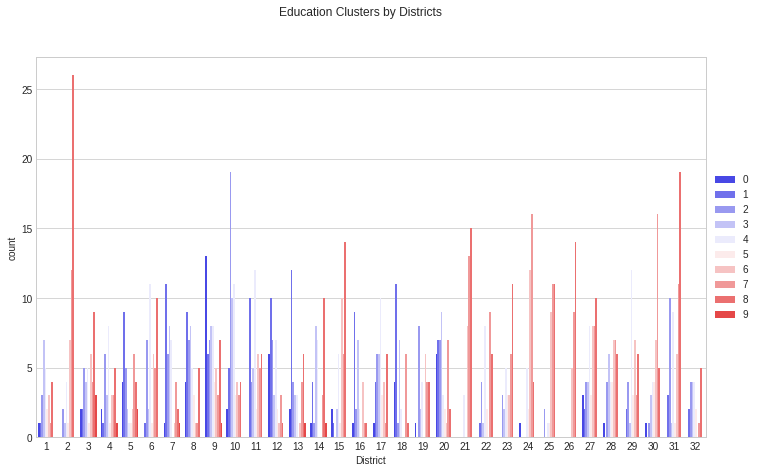

In [20]:
fig,ax=plt.subplots(1,figsize=(12,7))
plt.suptitle('Education Clusters by Districts')
sns.countplot(x="District",hue="Education Clusters", 
              data=school_explorer,ax=ax,palette='bwr')
ax.legend(loc='center left',bbox_to_anchor=(1,.5))
ax.set_xticklabels(range(1,33));

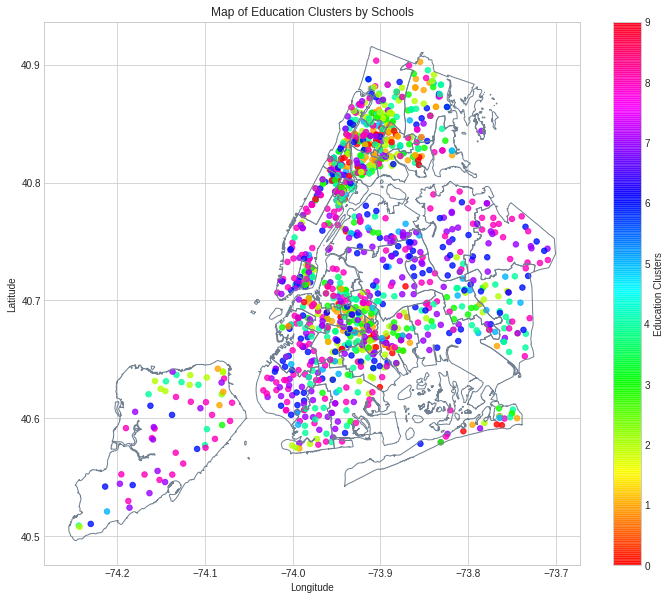

In [21]:
fig,ax=plt.subplots(1,figsize=(12,10))
school_explorer.plot(kind="scatter",x="Longitude",y="Latitude",
                     s=30,c="Education Clusters",ax=ax,
                     title='Map of Education Clusters by Schools',
                     cmap=cm.hsv,colorbar=True,alpha=.8)
districts.plot(ax=ax,color='none',edgecolor='slategray');

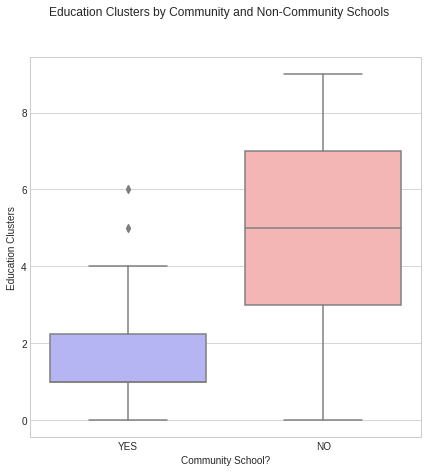

In [22]:
fig,ax=plt.subplots(1,figsize=(7,7))
plt.suptitle('Education Clusters by Community and Non-Community Schools')
sns.boxplot(x="Community School?",y="Education Clusters",
            data=school_explorer,ax=ax,palette='bwr')
ax.set_xticklabels(['YES','NO']);

The distribution by clusters has certain differences for two cases, but the problem regions are clearly the same.

<h1 class='font-effect-3d' style='color:#37c9e1; font-family:Orbitron;'>  &#x1F310; &nbsp; Manifold Learning </h1>
Let's divide schools into educational clusters using all numeric variables.

In [23]:
X=school_explorer[numeric_list+category_list+target_list]
nk=10; clf=KMeans(n_clusters=nk,random_state=23)
cluster_labels=clf.fit_predict(np.array(X))
school_explorer['Education Clusters']=cluster_labels
indices=list(X.groupby(school_explorer['Education Clusters']).mean()\
             .sort_values('Average Math Proficiency').index)
feature_pairs=dict(zip(indices,range(10,20)))
school_explorer['Education Clusters'].replace(feature_pairs,inplace=True)
feature_pairs=dict(zip(range(10,20),range(0,10)))
school_explorer['Education Clusters'].replace(feature_pairs,inplace=True)

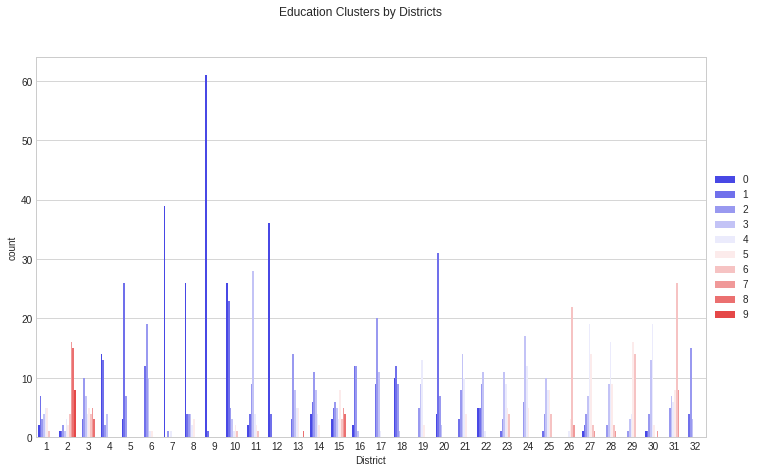

In [24]:
fig,ax=plt.subplots(1,figsize=(12,7))
plt.suptitle('Education Clusters by Districts')
sns.countplot(x="District",hue="Education Clusters", 
              data=school_explorer,ax=ax,palette='bwr')
ax.legend(loc='center left',bbox_to_anchor=(1,.5))
ax.set_xticklabels(range(1,33));

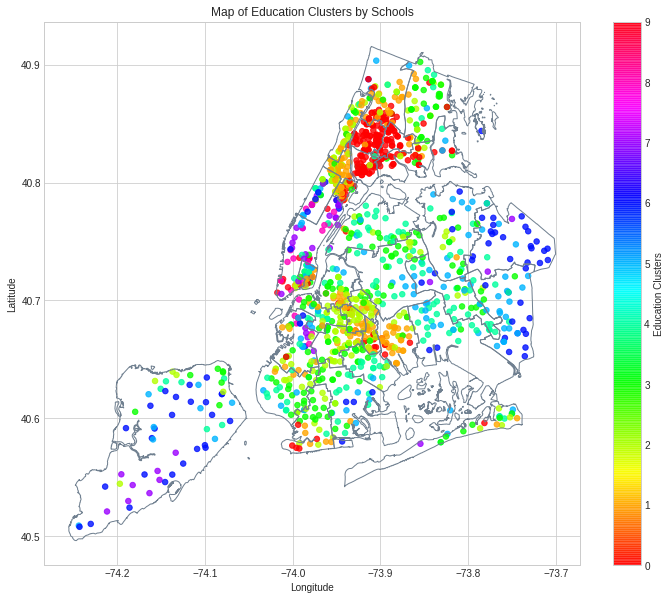

In [25]:
fig,ax=plt.subplots(1,figsize=(12,10))
school_explorer.plot(kind="scatter",x="Longitude",y="Latitude",
                     s=30,c="Education Clusters",ax=ax,
                     title='Map of Education Clusters by Schools',
                     cmap=cm.hsv,colorbar=True,alpha=.8)
districts.plot(ax=ax,color='none',edgecolor='slategray');

Now we can check whether the multidimensional data form a certain structure or don't. 

For this purpose, a probability algorithm and a transformation to two-dimensional space were used. 

The color on the chart still marks educational clusters.

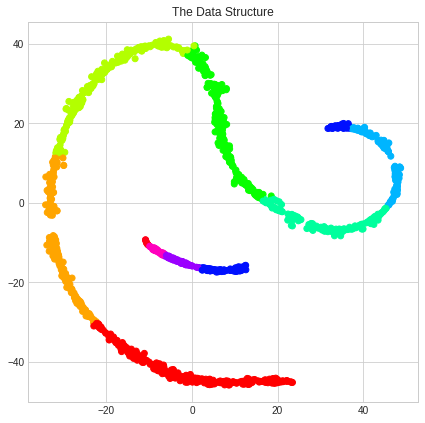

In [26]:
X=school_explorer[numeric_list+category_list+target_list]
tsne=TSNE(n_components=2,random_state=23)
X_embedded=tsne.fit_transform(np.array(X))
plt.figure(figsize=(7,7))
plt.scatter(X_embedded[:,1],X_embedded[:,0],cmap=cm.hsv,
            c=school_explorer['Education Clusters'])
plt.title('The Data Structure');

It seems like this clustering is done correctly. 

And the 7-9 clusters form a separate structure.

<h1 class='font-effect-3d' style='color:#37c9e1; font-family:Orbitron;'>  &#x1F310; &nbsp; Feature Correlation </h1>

Many numeric variables demonstrate a strong correlation.

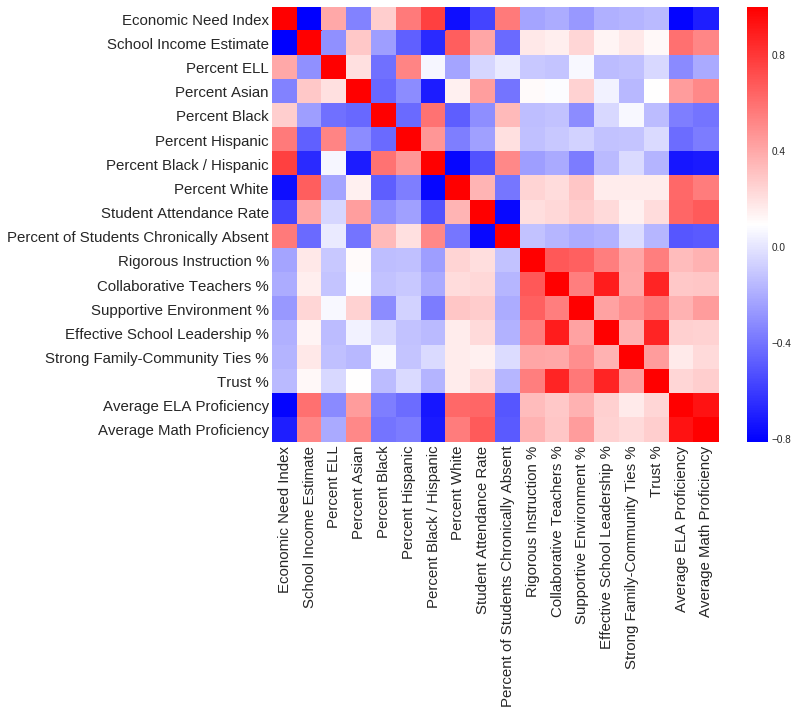

In [27]:
corr_matrix=school_explorer[numeric_list1[5:23]].corr()
fig,ax=plt.subplots(1,figsize=(10,8))
sns.heatmap(corr_matrix,ax=ax,cmap="bwr")
ax.set_xticklabels(corr_matrix.columns.values,size=15)
ax.set_yticklabels(corr_matrix.columns.values,size=15);

Education results (ELA & Math) are correlated really strongly so they can be combined into one indicator.

In [28]:
pearson=school_explorer[numeric_list+category_list+target_list]\
.corr(method='pearson')
corr_with_math_results=pearson.iloc[-1]
corr_with_math_results[abs(corr_with_math_results).argsort()[::-1]][:20]\
.to_frame().style.background_gradient(cmap='bwr')\
.set_properties(**{'color':'black','font-family':'Roboto','font-size':'120%'})

,Average Math Proficiency
Average Math Proficiency,1
Average ELA Proficiency,0.935253
Percent Black / Hispanic,-0.718155
Economic Need Index,-0.704222
Student Attendance Rate,0.679338
Grade 5 Math 4s - All Students,0.625105
Grade 3 Math 4s - All Students,0.623729
Grade 4 Math 4s - All Students,0.617929
Grade 5 ELA 4s - All Students,0.608659
Grade 4 ELA 4s - All Students,0.599617


In [29]:
pearson=school_explorer[numeric_list+category_list+target_list]\
.corr(method='pearson')
corr_with_ela_results=pearson.iloc[-2]
corr_with_ela_results[abs(corr_with_ela_results).argsort()[::-1]][:20]\
.to_frame().style.background_gradient(cmap='bwr')\
.set_properties(**{'color':'black','font-family':'Roboto','font-size':'120%'})

,Average ELA Proficiency
Average ELA Proficiency,1
Average Math Proficiency,0.935253
Economic Need Index,-0.794865
Percent Black / Hispanic,-0.732782
Student Attendance Rate,0.637642
Percent White,0.631241
School Income Estimate,0.601464
Grade 5 ELA 4s - All Students,0.574409
Grade 4 ELA 4s - All Students,0.542865
Grade 5 Math 4s - All Students,0.540469


<h1 class='font-effect-3d' style='color:#37c9e1; font-family:Orbitron;'> &#x1F310; &nbsp; Let's Go Ahead </h1>

To be continued...

&#x1F4D8; &nbsp; [PASSNYC. Comparing All Districts with 5th District](https://www.kaggle.com/olgabelitskaya/passnyc-comparing-all-districts-with-5th-district/notebook)